<a href="https://colab.research.google.com/github/ychu19/yelp-review-sentiment-analysis/blob/main/yelp_data_sentiment_presentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import json
import re
import string
import seaborn as sns # for plots
import matplotlib.pyplot as plt # for plots

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import tensorflow_hub as hub # for pretrained data
import tensorflow_datasets as tfds 
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def read_json(file, max_lines):
  """Read a number of lines of the json file"""
  count = 1
  data = []
  with open(file, 'r') as f: # 'r' means 'read'; 'w' means 'write
    for line in f:
      if count <= max_lines:
        dict_ = json.loads(line)
        dict_['five_stars'] = 1 if dict_['stars'] == 5.0 else 0 # created an one-hot feature for top reviews
        data.append(dict_)
        count+=1
      else:
        break
  return data

In [ ]:
path = "/content/drive/My Drive/data/yelp_academic_dataset_review.json"
d = read_json(path, 200000)

In [ ]:
dt = pd.DataFrame(d)
dt.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,five_stars
0,xQY8N_XvtGbearJ5X4QryQ,OwjRMXRC0KyPrIlcjaXeFQ,-MhfebM0QIsKt87iDN-FNw,2.0,5,0,0,"As someone who has worked with many museums, I...",2015-04-15 05:21:16,0
1,UmFMZ8PyXZTY2QcwzsfQYA,nIJD_7ZXHq-FX8byPMOkMQ,lbrU8StCq3yDfr-QMnGrmQ,1.0,1,1,0,I am actually horrified this place is still in...,2013-12-07 03:16:52,0
2,LG2ZaYiOgpr2DK_90pYjNw,V34qejxNsCbcgD8C0HVk-Q,HQl28KMwrEKHqhFrrDqVNQ,5.0,1,0,0,I love Deagan's. I do. I really do. The atmosp...,2015-12-05 03:18:11,1
3,i6g_oA9Yf9Y31qt0wibXpw,ofKDkJKXSKZXu5xJNGiiBQ,5JxlZaqCnk1MnbgRirs40Q,1.0,0,0,0,"Dismal, lukewarm, defrosted-tasting ""TexMex"" g...",2011-05-27 05:30:52,0
4,6TdNDKywdbjoTkizeMce8A,UgMW8bLE0QMJDCkQ1Ax5Mg,IS4cv902ykd8wj1TR0N3-A,4.0,0,0,0,"Oh happy day, finally have a Canes near my cas...",2017-01-14 21:56:57,0


In [ ]:
dt.groupby(["stars"])["stars"].count()

stars
1.0    27567
2.0    16501
3.0    22322
4.0    45562
5.0    88048
Name: stars, dtype: int64

In [ ]:
stars_tab = pd.crosstab(index=dt["stars"],
                        columns="count")
stars_tab/stars_tab.sum()

col_0,count
stars,
1.0,0.137835
2.0,0.082505
3.0,0.111610
4.0,0.227810
5.0,0.440240


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


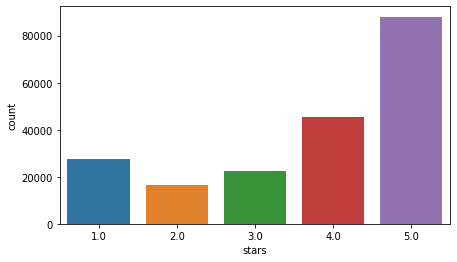

In [ ]:
filter_data = dt.dropna(subset=['stars'])
plt.figure(figsize=(7,4))
sns.countplot(filter_data['stars'])
# plt.savefig('imbalanced_reviews.jpeg')

In [ ]:
new_n = len(dt[dt['stars']==2.0]) # 8186 # 16501
Y_1 = dt[dt['stars']==1.0].sample(n=new_n, random_state=0)
Y_2 = dt[dt['stars']==2.0].sample(n=new_n, random_state=0) 
Y_3 = dt[dt['stars']==3.0].sample(n=new_n, random_state=0)
Y_4 = dt[dt['stars']==4.0].sample(n=new_n, random_state=0)
Y_5 = dt[dt['stars']==5.0].sample(n=new_n, random_state=0)

In [ ]:
rows = [Y_1, Y_2, Y_3, Y_4, Y_5]
dt = pd.concat(rows).sample(frac=1)
dt.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,five_stars
13422,tUhqF9AlcFRjr5cZC8AreQ,BRAuNgJGolSgAEgVZLedGw,surU3O61Ik5CQ_8fbHgdGQ,4.0,0,0,0,I had Trish. She did a gel manicure for me. Un...,2015-08-30 22:55:55,0
143998,uaRqbd7jY9erwOzxFlCrpQ,kn5pJIE5i-oujc_lyJB5BQ,qiJq8NukhBxAHAE57bnrxw,1.0,11,0,0,The experience at the very beginning should ha...,2016-08-08 03:54:08,0
82596,XF1zNk-X00G197vtpdwGpQ,ySOWHay3yeaadfuXOuagMg,hDJZh2TD9f-TVEVun75IJg,4.0,1,0,0,Great Patio and relaxing place to have lunch. ...,2014-02-08 19:28:47,0
119952,-Z8uacxHLtF6XI8puuEXCg,9peRQNqhd_uqt-Rh83zwjw,sAmmv3ffj99CN85Wj0zF3A,2.0,0,0,0,Went in last week for a manicure. The place wa...,2017-06-09 20:11:31,0
72658,O4fhs-tTAsQt7TXTFz29HQ,z3WHx5PVY6BglO4d6Uo9Ww,bzWo5eA5zZjktINg8DdAjw,2.0,2,0,0,O-VER-RA-TED.\n\nIt is pretty bad ass that I c...,2008-08-30 20:30:50,0


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


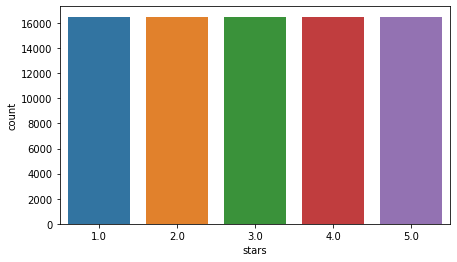

In [ ]:
plt.figure(figsize=(7,4))
sns.countplot(dt['stars'])
# plt.savefig('adjusted_samples.jpeg')

## Logistic Regression with `sklearn`

In [ ]:
## shuffle split with vectorization
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression

def cross_val_logit(X, Y, multi_class):
  """
  1. split training and test sets with train_test_split()
  2. pre-process the review texts with CountVectorizer() and fit_transform the training set
  3. transform the test vector 
  4. transform with tf-idf
  5. apply logistic regression, with the option to have multinomial logit (for binary logit use "auto")
  6. return a accuracy score with the test set
  """
  train_X, test_X, train_Y, test_Y = train_test_split(
      X, Y, test_size = 0.33)
  count_vect = CountVectorizer(stop_words='english',max_df=0.85)
  train_vect = count_vect.fit_transform(train_X)
  test_vect = count_vect.transform(test_X)

  train_tf_transformer = TfidfTransformer(use_idf=True).fit(train_vect)
  train_tf = train_tf_transformer.transform(train_vect)

  test_tf = train_tf_transformer.transform(test_vect)

  log_reg = LogisticRegression(multi_class=multi_class, solver='lbfgs', max_iter=400)
  # lbfgs stand for: "Limited-memory Broyden–Fletcher–Goldfarb–Shanno Algorithm"
  # default max_iter = 100 --> returns error code saying that it couldn't converge 
  log_reg.fit(train_tf, train_Y)

  return log_reg.score(test_tf, test_Y)

In [ ]:
cross_val_logit(dt.text, dt.five_stars, "auto")

0.875785066294487

In [ ]:
cross_val_logit(dt.text, dt.five_stars, "auto")

0.8769970984684321

In [ ]:
cross_val_logit(dt.text, dt.five_stars, "auto")

0.8770705549638227

In [ ]:
cross_val_logit(dt.text, dt.five_stars, "auto")

0.8750872295882763

In [ ]:
cross_val_logit(dt.text, dt.five_stars, "auto")

0.8783560436331582

## ANN with `TensorFlow`

### Pre-process the text data

In [ ]:
## remove stopwords

stops=" | ".join(set(stopwords.words("english")))
stops = '(?:' + stops + ')'

def custom_standardization(input_data):
  """
  1. make the texts lowercase
  2. remove periods
  3. remove stopwords
  4. remove double white space
  5. remove 's
  """
  lowercase = tf.strings.lower(input_data)
  no_periods = tf.strings.regex_replace(lowercase, '\.', '') # remove periods
  no_stop_words = tf.strings.regex_replace(no_periods, stops, ' ')
  cleaned_double_spaces = tf.strings.regex_replace(no_stop_words, '  ', ' ')
  cleaned_data = tf.strings.regex_replace(cleaned_double_spaces, '[%s]' % re.escape(string.punctuation),'')
  return cleaned_data

In [ ]:
dt.text = custom_standardization(dt.text)

### Split training, validation, and test data

In [ ]:
## separate training, validation, and test data 

def train_val_test(X, Y, random_state):
  """
  Split dataset into training, validation, and test sets:
  Step 1: Split training and test sets
  Step 2: Sample rows from the training set for the validation set 
  Returns train_X, train_Y, val_X, val_Y, test_X, test_Y
  """
  X = X.to_numpy()
  train_X, test_X, train_Y, test_Y = train_test_split(
      X, Y, test_size = 0.33, random_state = random_state
  )
  train_X, val_X, train_Y, val_Y = train_test_split(
      train_X, train_Y, test_size = 0.2, random_state = random_state
  )

  return train_X, train_Y, val_X, val_Y, test_X, test_Y

train_X, train_Y, val_X, val_Y, test_X, test_Y = train_val_test(dt.text, dt.five_stars, 4)

### Use the pre-trained embedding from `hub`

In [ ]:
embedding_pretrained = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer=hub.KerasLayer(embedding_pretrained, input_shape = [],
                         dtype=tf.string, trainable=True)

In [ ]:
hub_layer([train_X[0]])

<tf.Tensor: shape=(1, 50), dtype=float32, numpy=
array([[ 0.42034665, -0.342544  , -0.08545388,  0.10272005, -0.14290535,
        -0.07105406,  0.36032107,  0.11547501, -0.2942254 ,  0.34731045,
         0.20038034,  0.2247732 ,  0.11733465,  0.20789732, -0.30662125,
        -0.15826738, -0.13545187,  0.3926795 ,  0.03041909, -0.19296773,
        -0.05336305, -0.29942262, -0.13122743,  0.19386819, -0.16842212,
         0.04101687, -0.350889  , -0.0814321 ,  0.21683893,  0.1433156 ,
        -0.06198009,  0.2780368 ,  0.28872767, -0.42891008,  0.1032379 ,
         0.23199621, -0.11754638,  0.09818706,  0.12397266, -0.27283725,
         0.14140116, -0.07294545,  0.1966368 ,  0.0215362 , -0.34794047,
         0.10982995, -0.11843537,  0.0687242 ,  0.00988145,  0.04476667]],
      dtype=float32)>

### Build the model

In [ ]:
def add_layers(model, iteration, neurons, activation, regularizer, initializer, dropout):
  """create multiple hidden layers with dropouts"""
  for i in range(iteration+1):
    model.add(tf.keras.layers.Dense(neurons, activation=activation, kernel_regularizer=regularizer, kernel_initializer=initializer))
    model.add(tf.keras.layers.Dropout(dropout))

l2_reg = tf.keras.regularizers.L2(l2=0.01)
dropout = 0.01

model = tf.keras.Sequential()
model.add(hub_layer)
add_layers(model, iteration=3, neurons=50, activation='elu', regularizer=None, initializer='he_normal', dropout=dropout)
model.add(layers.Dense(1,activation='sigmoid'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 50)                48190600  
_________________________________________________________________
dense_33 (Dense)             (None, 50)                2550      
_________________________________________________________________
dropout_26 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 50)                2550      
_________________________________________________________________
dropout_27 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 50)                2550      
_________________________________________________________________
dropout_28 (Dropout)         (None, 50)               

In [ ]:
loss_ = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics_ = tf.keras.metrics.BinaryAccuracy()
opt = tf.keras.optimizers.Adam(learning_rate=0.01)

model.compile(loss = loss_,
              optimizer=opt, # change learning rate here!
              metrics=['accuracy'])

model.save_weights('five_stars')

In [ ]:
model.load_weights('five_stars')

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=3)
epochs = 15
history = model.fit(
    train_X, train_Y,
    validation_data=(val_X,val_Y),
    batch_size=200,
    epochs = epochs,
    callbacks=[earlystop])

Epoch 1/15
222/222 [==============================] - 106s 478ms/step - loss: 0.6921 - accuracy: 0.8077 - val_loss: 0.6843 - val_accuracy: 0.8312
Epoch 2/15
222/222 [==============================] - 105s 474ms/step - loss: 0.6828 - accuracy: 0.8384 - val_loss: 0.6942 - val_accuracy: 0.8424
Epoch 3/15
222/222 [==============================] - 105s 471ms/step - loss: 0.6819 - accuracy: 0.8436 - val_loss: 0.6823 - val_accuracy: 0.8425
Epoch 4/15
222/222 [==============================] - 105s 472ms/step - loss: 0.6816 - accuracy: 0.8497 - val_loss: 0.6843 - val_accuracy: 0.8298
Epoch 5/15
222/222 [==============================] - 105s 475ms/step - loss: 0.6809 - accuracy: 0.8470 - val_loss: 0.6844 - val_accuracy: 0.8300
Epoch 6/15
222/222 [==============================] - 105s 472ms/step - loss: 0.6812 - accuracy: 0.8431 - val_loss: 0.6834 - val_accuracy: 0.8372


### Evaluating the Model with Test Set

In [ ]:
results = model.evaluate(test_X, test_Y, verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

851/851 - 1s - loss: 0.6824 - accuracy: 0.8387
loss: 0.682
accuracy: 0.839
